# Loan Default Prediction
## Overview
This documentation describes a machine learning project that predicts loan default risk using LightGBM and other techniques. The model analyzes borrower characteristics to classify loans as likely to default (1) or not (0).

## Importing Libraries

In [1]:
# Step 1: Load Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

## Loading and Previewing Dataset

In [3]:
# Step 2: Load a Sample of Data
df = pd.read_csv("loan.csv", low_memory=False)
df = df.sample(frac=0.05, random_state=42)

In [10]:
df.head()

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,inq_last_6mths,open_acc,pub_rec,revol_bal,...,earliest_cr_line_Sep-2007,earliest_cr_line_Sep-2008,earliest_cr_line_Sep-2009,earliest_cr_line_Sep-2010,earliest_cr_line_Sep-2011,earliest_cr_line_Sep-2012,earliest_cr_line_Sep-2013,earliest_cr_line_Sep-2014,initial_list_status_w,application_type_Joint App
1758049,35000,12.12,1164.51,90000.0,0,3.51,0.0,14.0,0.0,1347,...,False,False,False,False,False,False,False,False,True,False
900721,15000,7.49,466.53,100000.0,0,6.71,0.0,16.0,0.0,7425,...,False,False,False,False,False,False,False,False,True,False
1727912,24000,21.15,651.31,58000.0,0,15.50,0.0,10.0,0.0,24123,...,False,False,False,False,False,False,False,False,False,False
2153213,5000,9.93,161.18,46750.0,0,11.09,1.0,8.0,0.0,5449,...,False,False,False,False,False,False,False,False,True,False
1360732,6550,24.74,259.53,42000.0,0,18.71,3.0,3.0,0.0,4751,...,False,False,False,False,False,False,False,False,False,False


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65141 entries, 1758049 to 1321153
Columns: 37315 entries, loan_amnt to application_type_Joint App
dtypes: bool(37301), float64(11), int64(3)
memory usage: 2.3 GB


In [4]:
columns_to_drop = [
                'member_id', 'funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'url', 'desc', 'delinq_2yrs',
                'settlement_term', 'mths_since_last_delinq', 'mths_since_last_record', 'out_prncp', 'out_prncp_inv',
                'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
                'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
                'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low',
                'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code',
                'annual_inc_joint',	'dti_joint', 'verification_status_joint', 'acc_now_delinq',
                'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
                'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',	'open_rv_24m',	'max_bal_bc',
                'all_util',	'total_rev_hi_lim',	'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths',
                'avg_cur_bal', 'bc_open_to_buy', 'bc_util',	'chargeoff_within_12_mths',	'delinq_amnt',
                'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
                'mths_since_recent_bc',	'mths_since_recent_bc_dlq',	'mths_since_recent_inq', 
                'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
                'num_actv_rev_tl',	'num_bc_sats',	'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
                'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',	'num_tl_30dpd',
                'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',	'pct_tl_nvr_dlq', 'percent_bc_gt_75',
                'tax_liens', 'tot_hi_cred_lim',	'total_bal_ex_mort', 'total_bc_limit', 
                'total_il_high_credit_limit', 'revol_bal_joint', 'sec_app_fico_range_low',
                'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
                'sec_app_mort_acc',	'sec_app_open_acc',	'sec_app_revol_util', 'sec_app_open_act_il',
                'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 
                'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog','hardship_flag',	
                'hardship_type', 'hardship_reason',	'hardship_status', 'deferral_term', 'hardship_amount', 
                'hardship_start_date',	'hardship_end_date', 'payment_plan_start_date',	'hardship_length',	'hardship_dpd',
                'hardship_loan_status',	'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount',	'hardship_last_payment_amount',
                'disbursement_method', 'debt_settlement_flag', 'debt_settlement_flag_date','settlement_status',	
                'settlement_date', 'settlement_amount', 'settlement_percentage',
]

df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

## Data Cleaning
- Handling missing values
- class Imbalance using smote

In [5]:
# Step 4: Drop Rows with Too Many Missing Values
df.dropna(thresh=int(0.7 * df.shape[1]), inplace=True)

In [6]:
# Step 5: Drop Columns with Too Many Missing Values
df.dropna(axis=1, thresh=int(0.7 * len(df)), inplace=True)

In [7]:
# Step 6: Convert Target Column to Binary
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]  # Binary classification
df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

In [8]:
# Step 7: Encode Categorical Features
df = pd.get_dummies(df, drop_first=True)

In [13]:
# Step 8: Fill Remaining Missing Values with Median (column by column)
for col in df.columns:
    if df[col].dtype in [np.float64, np.int64, np.float32, np.int32]:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)


In [14]:
# Step 9: Separate Features and Target
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [19]:
# Step 12: Split into train and test sets BEFORE SMOTE
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

In [20]:
# Step 11: Define a compact feature list
selected_features = [
    'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 
    'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'revol_bal', 
    'revol_util', 'total_acc'
]

# Only use these columns if they exist in the DataFrame
selected_features = [col for col in selected_features if col in df.columns]

X = df[selected_features]
y = df['loan_status']


In [22]:
# Step 13: Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [23]:
# Step 14: Scale the features after SMOTE
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

## Model Training
### LightGBM Model

In [26]:
# Step 15: Train LightGBM Model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_res, y_train_res)

[LightGBM] [Info] Number of positive: 41681, number of negative: 41681
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 83362, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(random_state=42)

## Model Evaluation

In [28]:
# Step 16: LightGBM Predictions and Evaluation
y_pred_lgb = lgb_model.predict(X_test_scaled)

print("\nLightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb))


LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     10421
           1       0.25      0.01      0.01      2608

    accuracy                           0.80     13029
   macro avg       0.53      0.50      0.45     13029
weighted avg       0.69      0.80      0.71     13029



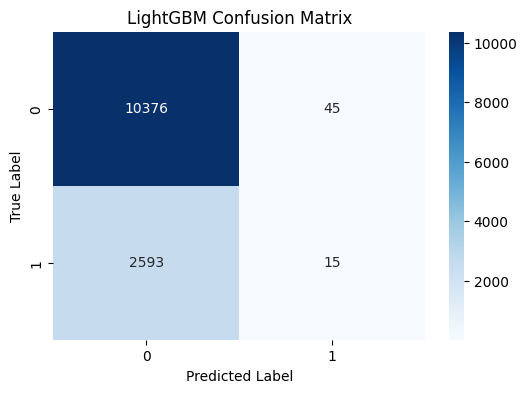

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# LightGBM Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_lgb), annot=True, fmt='d', cmap='Blues')
plt.title('LightGBM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Evaluation Metrics:
--------------------------------------------------------
| Metric          | Class 0 (Non-Default) | Class 1 (Default) |
|-----------------|------------------------|--------------------|
| Precision       | 0.80                   | 0.25               |
| Recall          | 1.00                   | 0.01               |
| F1 Score        | 0.89                   | 0.01               |
| Support         | 10421                  | 2608               |

Overall Accuracy: 80%
Macro Avg F1 Score: 0.45
Weighted Avg F1 Score: 0.71

Key Observations:
- Excellent performance for non-defaulters (Class 0).
- Extremely poor performance for defaulters (Class 1).
- Imbalanced learning persists even after applying SMOTE.


## Recommendations for Lenders:

1. Model Deployment Strategy:
   - Use the model to confidently auto-approve low-risk applicants.
   - Flag medium-risk or low-confidence predictions for manual review.

2. Increase Sensitivity to Defaulters:
   - Tune LightGBM decision threshold to increase recall.
   - Use custom loss functions to penalize false negatives more.

3. Feature Engineering:
   - Add risk-based features such as:
     * Credit utilization ratio
     * Length of credit history
     * Employment duration
     * Loan type/purpose
   - Use domain expertise to add predictive power for default class.

4. Model Improvements:
   - Consider ensemble models like Random Forest, XGBoost, or Neural Nets.
   - Explore anomaly detection for rare defaulter class.

5. Operational Policy Integration:
   - Define decision thresholds for:
     * Auto-approve
     * Manual review
   - Retrain model periodically with updated borrower data.

6. Ethical and Regulatory Compliance:
   - Ensure fairness (no bias by gender, race, etc.).
   - Conduct regular audits for fairness and performance drift.

## Conclusion:
Current model performs well for safe borrowers but poorly for risky ones.
Recommended: Refine features, apply threshold tuning, and include manual risk review
to improve default prediction accuracy and lending decisions.
